##### Copyright (c) 2021 Spanish National Research Council

In [2]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

This tutorial is based on the Tensorflow tutorial [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series?hl=en#multi-step_models).

The aim of this notebook is to forecast COVID-19 time series using TensorFlow. The models are Convolutional and Recurrent Neural Networks (CNNs and RNNs). 

Concepts:
* **Univariate Time Series**: These are datasets where only a single variable is observed at each time, such as temperature each hour. The example in the previous section is a univariate time series dataset.
* **Multivariate Time Series**: These are datasets where two or more variables are observed at each time. 
* **One-Step Forecast**: This is where the next time step (t+1) is predicted.
* **Multi-Step Forecast**: This is where two or more future time steps are to be predicted.

## Index

* [Forecast for a single time step](#i1):
  * [A single feature](#i11).
  * [All features](#i12).
* [Forecast multiple steps](#i2):
  * [Single-shot](#i21): Make the predictions all at once.
  * [Autoregressive](#i22): Make one prediction at a time and feed the output back to the model.

## Setup

In [158]:
import os
import sys
import pathlib
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, Lambda, Conv1D

from IPython.display import Image
from IPython.core.display import HTML 

mpl.rcParams['figure.figsize'] = (14, 9)
mpl.rcParams['axes.grid'] = False

sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))
# from utils import Paths

## COVID-19 dataset

This project uses a covid-19 data from Cantabria (Spain) obtained from:

1. [Cantabria Health Service](https://www.scsalud.es/coronavirus).
2. [Cantabria Institute of Statistics](https://www.icane.es/covid19/dashboard/home/home) (ICANE).
3. [Ministry of Health, Consumer Affairs and Social Welfare](https://www.mscbs.gob.es).

To generate and process regional COVID-19 data from scratch use:
```bash
python src/data.py
python src/data.py --files covid
```
The dataset to be used is located in ./data/processed/covid/region/all_data_cantb.csv. This dataset contains 20 different features such as daily positive cases, daily deaths, hospital and ICU bed occupancy, daily pcr tests, 7-day and 14-day cumulative incidence and the number of people vaccinated. These were collected every day, beginning in 29 February 2020.


If you are running this notebook on Google Collab you must upload the file and execute the following code cell:

In [159]:
df = pd.read_csv('all_data_cantb.csv', sep=',')
df = df.set_index('date')

Otherwise, run the following cell:

In [ ]:
PATHS = Paths()
data_path = PATHS.processed / 'covid' / 'region' / 'all_data_cantb.csv'
df = pd.read_csv(data_path, sep=',').copy()
df = df.set_index('date')

In [160]:
df.head()

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2020/02/29,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
2020/03/01,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
2020/03/02,9,0,10,0,0,0,0,10,0,1,10,0,0,0,0,0,0,0.9
2020/03/03,0,0,10,0,0,0,0,24,0,1,24,0,0,0,0,0,0,0.0
2020/03/04,0,0,10,0,0,0,0,24,0,1,24,0,0,0,0,0,0,0.0


Here is the evolution of a few features over time:

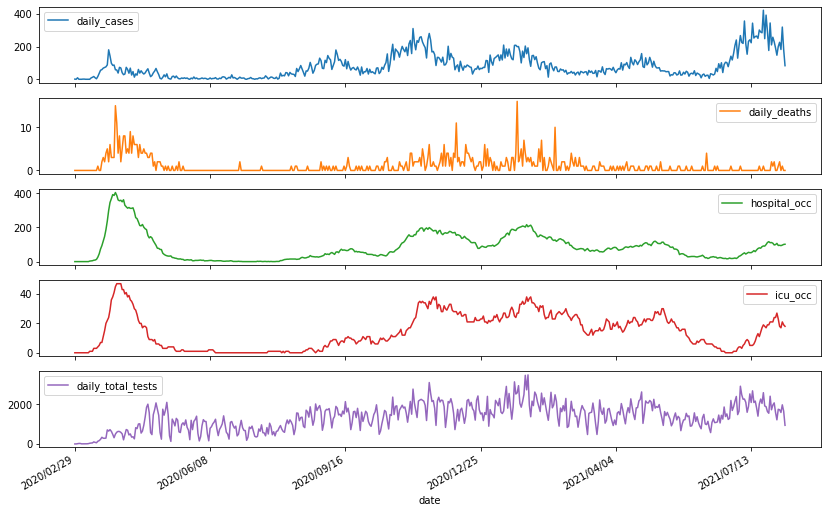

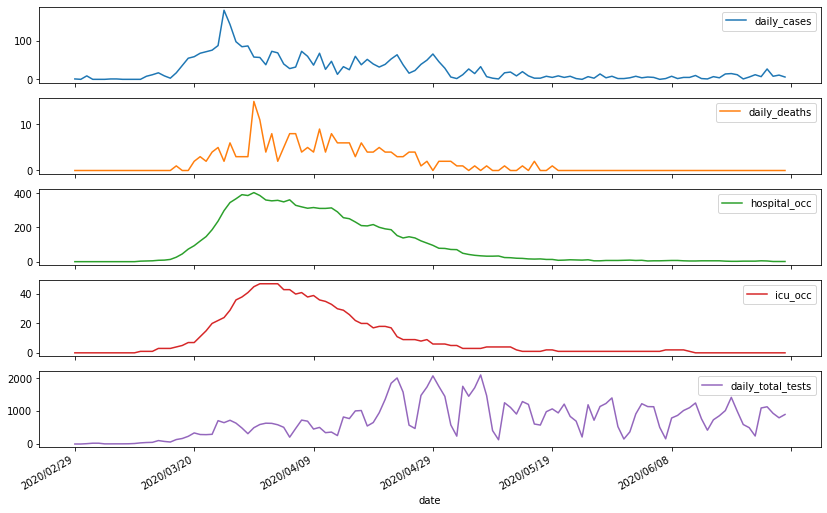

In [161]:
plot_cols = ['daily_cases', 'daily_deaths', 'hospital_occ', 'icu_occ', 'daily_total_tests']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:120]
plot_features.index = df.index[:120]
_ = plot_features.plot(subplots=True)

## Inspect
Next, look at the statistics of the dataset. All variables must be positive and `date` column should be date type.

In [162]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
daily_cases,526.0,80.760456,74.828920,0.0,26.250000,60.000000,114.750000,422.0
daily_deaths,526.0,1.123574,1.968789,0.0,0.000000,0.000000,1.000000,16.0
cumulative_cases,526.0,15846.741445,12587.817314,1.0,3108.750000,14881.000000,27161.500000,42404.0
cumulative_deaths,526.0,345.437262,178.013918,0.0,211.000000,291.500000,547.000000,589.0
icu_occ,526.0,14.256654,11.988117,0.0,2.000000,12.000000,23.750000,47.0
daily_antibody_tests,526.0,84.068441,163.308435,0.0,0.000000,38.500000,83.000000,1284.0
daily_antigen_tests,526.0,39.359316,47.013779,0.0,0.000000,0.000000,73.000000,245.0
daily_pcr_tests,526.0,1243.619772,637.336738,0.0,743.750000,1273.500000,1726.250000,3307.0
vaccinated_pp,526.0,30053.268061,74238.952101,0.0,0.000000,0.000000,0.000000,353807.0
hospital_occ,526.0,85.391635,78.953336,1.0,24.000000,70.000000,121.000000,403.0


The processing of the data has been done before when the dataset has been generated.

## Split the data
I will use a `(80%, 15%, 5%)` split for the training, validation, and test sets. The data is **not** being randomly shuffled before splitting because:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [163]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.95)]
test_df = df[int(n*0.95):]

num_features = df.shape[1]

In [164]:
train_df.tail()

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2021/04/19,109,0,28847,558,22,43,69,1706,48830,94,1818,697,1263,120,218,3,0,0.059956
2021/04/20,90,0,28937,558,21,65,98,1670,50550,92,1833,708,1288,122,222,0,0,0.049100
2021/04/21,107,1,29044,559,18,21,73,2075,53153,89,2169,749,1333,129,230,0,0,0.049331
2021/04/22,119,0,29163,559,19,36,81,2131,55401,96,2248,734,1351,127,233,7,1,0.052936
2021/04/23,157,0,29320,559,19,52,97,2474,55727,92,2623,789,1452,136,250,0,0,0.059855


In [165]:
val_df.tail()

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2021/07/07,219,0,34636,578,5,9,147,2099,251771,47,2255,1491,2300,257,396,6,2,0.097118
2021/07/08,356,0,34992,578,6,12,167,2086,257496,52,2265,1640,2552,283,440,5,1,0.157174
2021/07/09,217,0,35209,578,8,21,135,1943,262731,45,2099,1617,2667,279,459,0,2,0.103383
2021/07/10,153,0,35362,578,9,0,122,1475,0,50,1597,1641,2743,283,473,5,1,0.095805
2021/07/11,232,0,35594,578,8,1,117,1768,0,55,1886,1669,2866,288,494,5,0,0.123012


In [166]:
test_df.tail()

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2021/08/03,226,2,41637,588,18,14,115,1597,339040,96,1726,1460,3619,252,623,1,0,0.130939
2021/08/04,182,0,41819,588,17,22,97,1468,348175,94,1587,1432,3517,247,606,0,0,0.114682
2021/08/05,319,1,42138,589,21,25,125,1823,350342,97,1973,1494,3414,258,588,3,4,0.161683
2021/08/06,183,0,42321,589,19,34,159,1460,353807,101,1653,1448,3349,250,577,4,0,0.110708
2021/08/07,83,0,42404,589,18,0,121,818,0,102,939,1340,3040,231,524,1,0,0.088392


## Normalize the data
Before training a neural network it is important to scale features. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [167]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

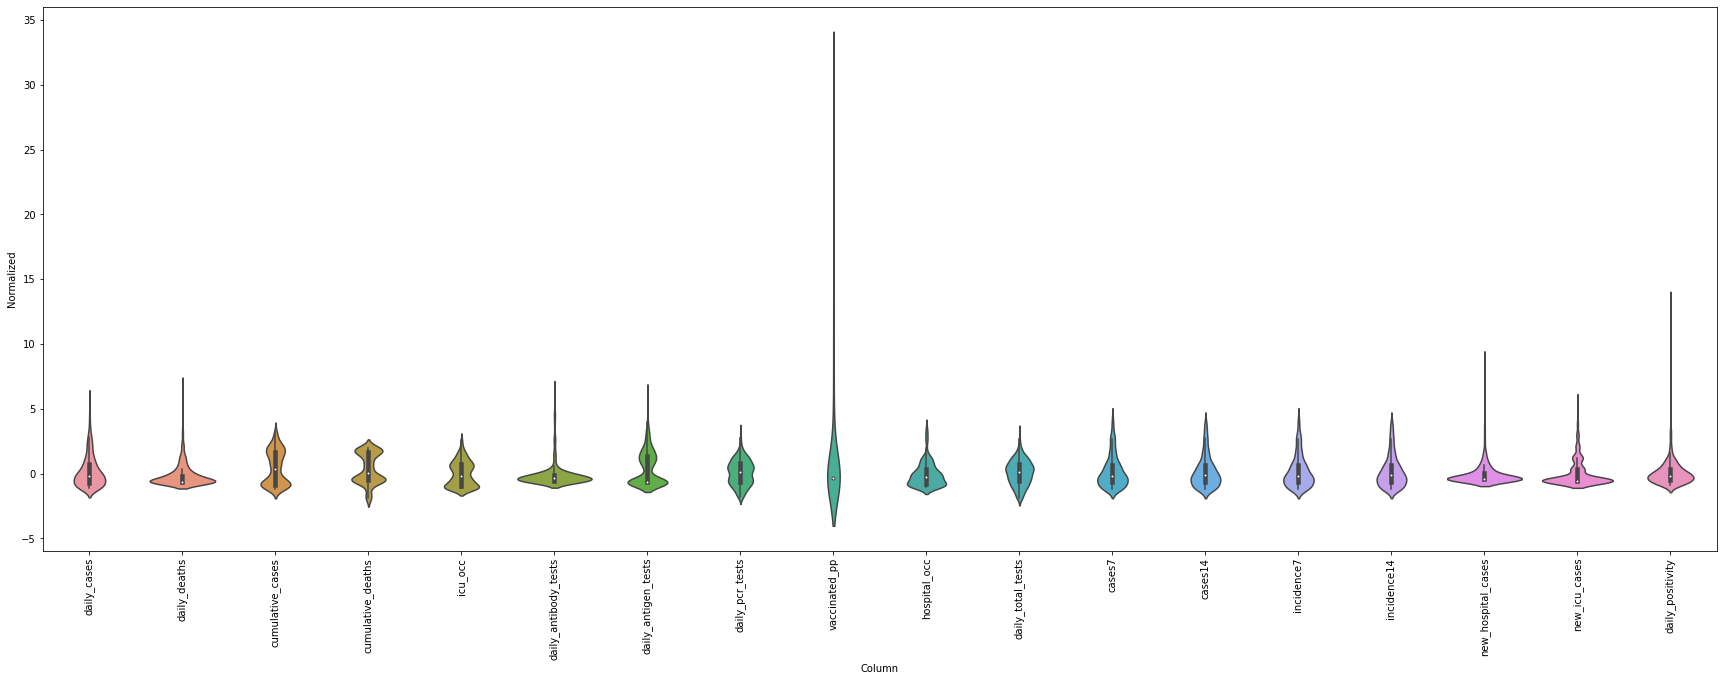

In [168]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(30, 10))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors. The feature `vaccinated_pp` has this form because the start of vaccination was almost one year later.

## Data windowing
Predictions will be based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

The variety of models (including Linear, dense, CNN and RNN models) will be use for:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

### 1. Indexes and offsets
The `WindowGenerator` class handles the indexes and offsets, splits windows of features into `(features, labels)` pairs and converts to `tf.data.Dataset`s the input DataFrames for training, evaluation, and test. The  `__init__` method includes:
* `input_width`: Size of the history window.
* `label_width`: Number of consecutive instants to predict.
* `shift`: Size of the time window from the history window to the last time instant you want to predict.

In [169]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [170]:
# Example of one prediction 15 days into the future, given 30 days of history.
w1 = WindowGenerator(input_width=30, label_width=1, shift=15,
                     label_columns=['daily_cases', 'daily_deaths'])
w1

Total window size: 45
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [44]
Label column name(s): ['daily_cases', 'daily_deaths']

### 2. Split
Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

In [171]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  
  return inputs, labels

WindowGenerator.split_window = split_window

In [172]:
# Stack three time slices:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 45, 18)
Inputs shape: (3, 30, 18)
labels shape: (3, 1, 2)


The code above took a batch of three 45-time step windows with 18 features at each time step. It splits them into a batch of 30-time step 18-feature inputs, and a 1-time step 1-feature label.

### 3. Plot

Plot method for split window.

In [173]:
def plot(self, model=None, plot_col=['daily_cases'], max_subplots=3):
    """
    Plot an example of the trained model using the inputs and the labels (target or expected values) obtained
    with split_window() method.
    Args:
        self: Class method.
        model: Model to make predictions.
            If it is None, it not makes predictions, only inputs and labels are plotted.
        plot_col: List of the columns names to predict.
        max_subplots: Maximum number of plots.

    Returns: Graph

    """
    inputs, labels = self.example
    # inputs = self.inputs
    # labels = self.labels

    # index of the column to plot
    plot_col_index = [self.column_indices.get(key) for key in plot_col]
    num_features = len(plot_col_index)
    # plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))  # len(inputs) = n batch
    it = 1
    for n in range(max_n):
        for m in range(num_features):
            plt.subplot(max_n, num_features, it)  # select subplot
            plt.ylabel(f'{plot_col[m]} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index[m]],
                      label='Inputs', marker='.', zorder=-10)
            it += 1

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col[m], None)
            else:
                label_col_index = plot_col_index[m]

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()
            plt.xlabel('Time [days]')
    plt.show()

WindowGenerator.plot = plot

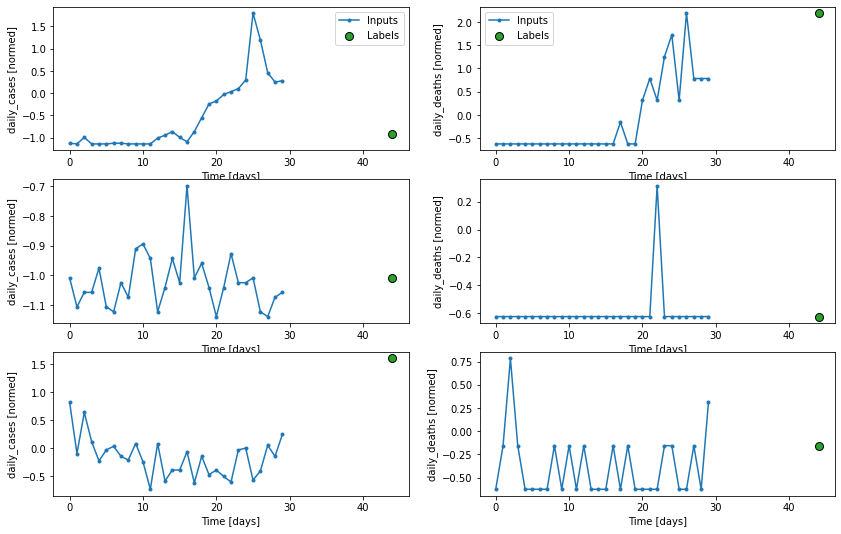

In [174]:
# Example
w1.example = example_inputs, example_labels
w1.plot(plot_col=['daily_cases', 'daily_deaths'])

### 4. Create `tf.data.Dataset`s
The `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs.

In [175]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.


In [176]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Single step models<a name="i1"></a>


### Single-output models<a name="i12"></a>

The simplest model predicts a **single feature's value—1 time step** (one day) into the future based only on the current conditions (using the value before the predicted value).


Start by building models to predict the `daily_cases` value one day into the future.

In [177]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['daily_cases'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['daily_cases']

In [178]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 18)
Labels shape (batch, time, features): (32, 1, 1)


#### Model 1: Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

Baseline will work less well if you make a prediction further in the future.

In [179]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [180]:
# Example of predicting single feature's value—1 time step (one day) into the future based only on the current conditions
baseline = Baseline(label_index=column_indices['daily_cases'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 4ms/step - loss: 0.3787 - mean_absolute_error: 0.4127


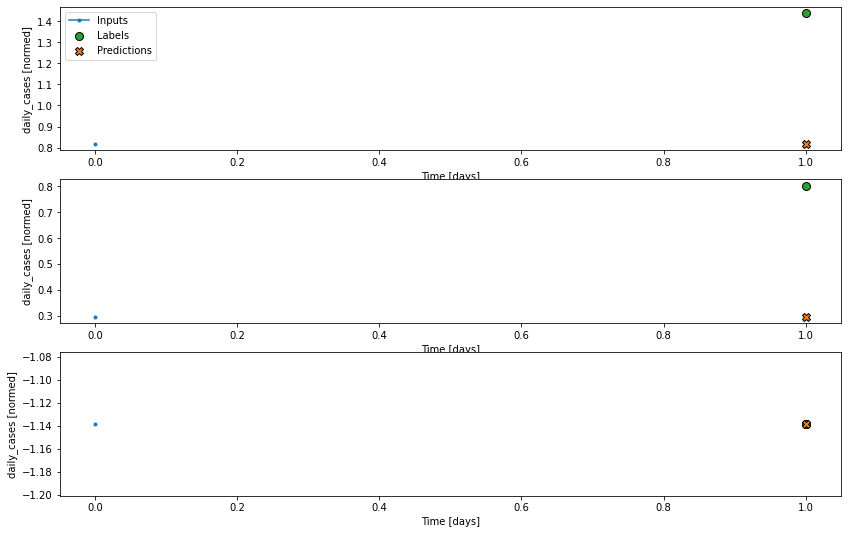

In [181]:
single_step_window.plot(baseline, plot_col=['daily_cases'], max_subplots=3)

Now, create a wider `WindowGenerator` that generates windows 30 days of consecutive inputs and labels at a time. The model still makes predictions one day into the future based on a single input time step. Each prediction is made independently with no interaction between time steps.

In [182]:
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/last_window.png")

In [184]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 18)
Output shape: (32, 30, 1)


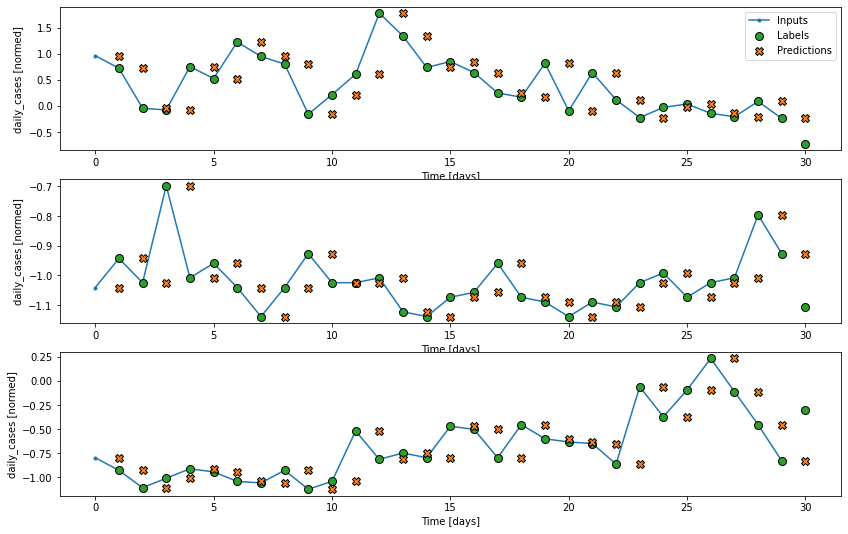

In [185]:
wide_window.plot(baseline, max_subplots=3)

In the above plots of three examples the single step model is run over the course of 30 days.

- The blue `Inputs` line shows the daily coronavirus cases at each time step. The model receives all features, this plot only shows the `daily_cases`.
- The green `Labels` dots show the target prediction value. 
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`. In this cases, the values of the predictions for an instant $t$ coincide with the value of the variable for an instant $t-1$.

#### Model 2: Linear
The simplest trainable model, a linear transformation between the input and output.

In [186]:
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png")

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [187]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [188]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 18)
Output shape: (32, 1, 1)


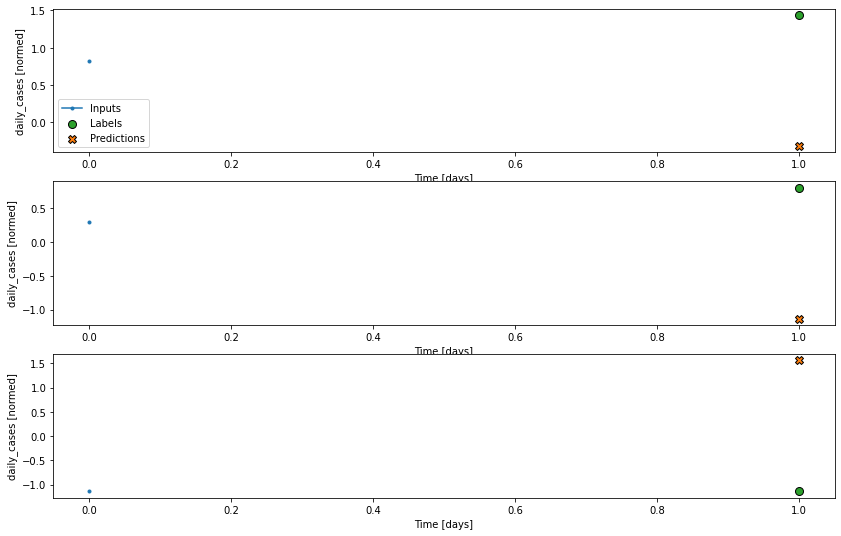

In [189]:
single_step_window.plot(linear)

Package the training procedure into a function:

In [190]:
def compile_and_fit(model, window, patience=3, MAX_EPOCHS = 20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [191]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
14/14 [==============================] - 1s 14ms/step - loss: 2.9464 - mean_absolute_error: 1.3565 - val_loss: 25.3878 - val_mean_absolute_error: 3.8835
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 2.5617 - mean_absolute_error: 1.2561 - val_loss: 23.6018 - val_mean_absolute_error: 3.7343
Epoch 3/20
14/14 [==============================] - 0s 7ms/step - loss: 2.2370 - mean_absolute_error: 1.1619 - val_loss: 22.1154 - val_mean_absolute_error: 3.6053
Epoch 4/20
14/14 [==============================] - 0s 6ms/step - loss: 1.9523 - mean_absolute_error: 1.0759 - val_loss: 20.7459 - val_mean_absolute_error: 3.4820
Epoch 5/20
14/14 [==============================] - 0s 8ms/step - loss: 1.7286 - mean_absolute_error: 1.0017 - val_loss: 19.4800 - val_mean_absolute_error: 3.3644
Epoch 6/20
14/14 [==============================] - 0s 6ms/step - loss: 1.5353 - mean_absolute_error: 0.9361 - val_loss: 18.2807 - val_mean_absolute_error: 3.2493
Epoch 7/20
14/14 [===

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps.




In [192]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 18)
Output shape: (32, 30, 1)


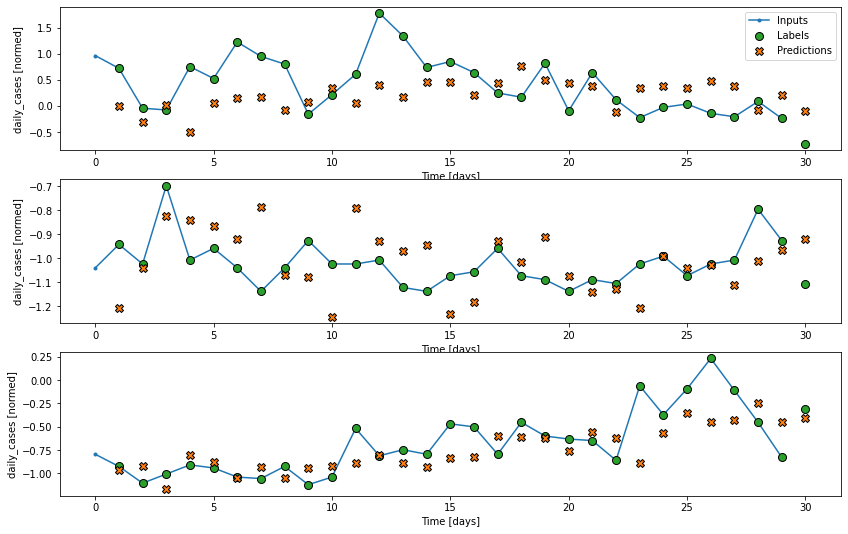

In [193]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

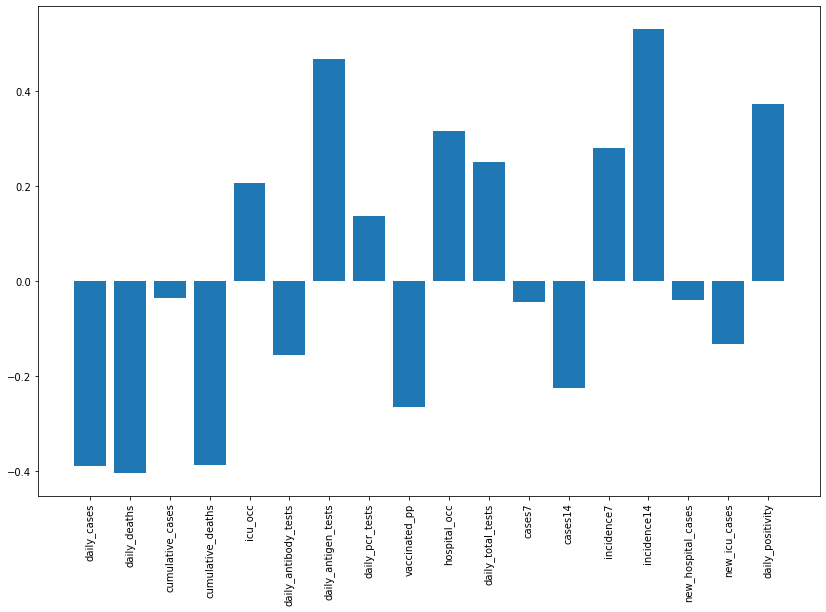

In [194]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `daily_cases`. This is one of the risks of random initialization. 

#### Model 3: Dense layers
It is a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output.

In [195]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
14/14 [==============================] - 1s 17ms/step - loss: 0.7614 - mean_absolute_error: 0.6911 - val_loss: 0.5646 - val_mean_absolute_error: 0.5845
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.2935 - mean_absolute_error: 0.3915 - val_loss: 0.9684 - val_mean_absolute_error: 0.8175
Epoch 3/20
14/14 [==============================] - 0s 11ms/step - loss: 0.2285 - mean_absolute_error: 0.3322 - val_loss: 1.4195 - val_mean_absolute_error: 1.0014
Epoch 4/20
3/3 [==============================] - 0s 4ms/step - loss: 1.9915 - mean_absolute_error: 1.1878


In this case, the activation set in each `Dense` layer was `ReLU`. The number of hiden layers and epochs can be modified.

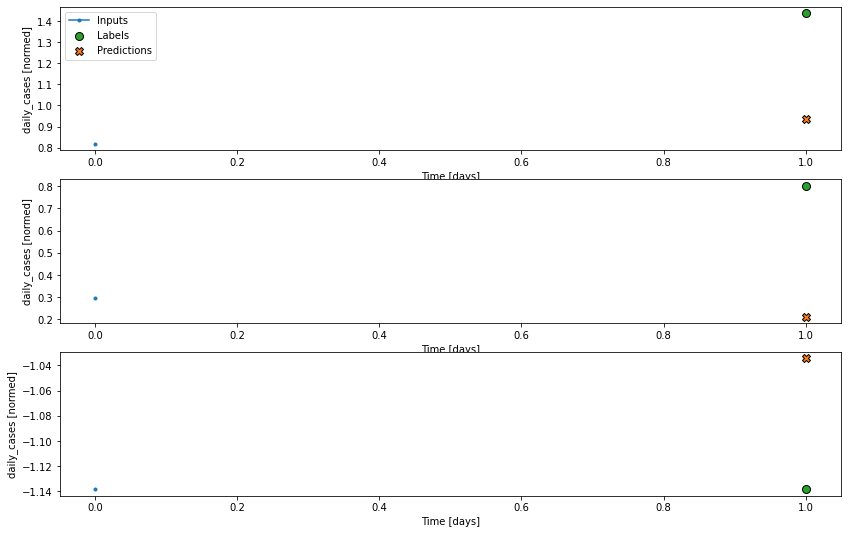

In [196]:
single_step_window.plot(dense)

#### Model 4: Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions.





In [197]:
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/conv_window.png")

The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

In [198]:
# Batches of 3-days inputs and 1-day labels:
conv_window = WindowGenerator(
    input_width=3,  # CONV_WIDTH
    label_width=1,
    shift=1,
    label_columns=['daily_cases'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['daily_cases']

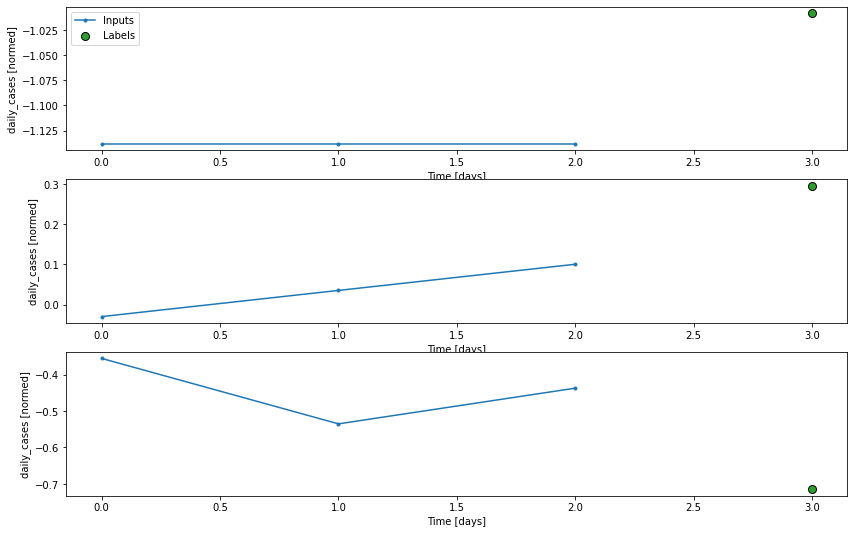

In [199]:
conv_window.plot()

Train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model.

In [200]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [201]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

3/3 [==============================] - 0s 4ms/step - loss: 1.0330 - mean_absolute_error: 0.8567


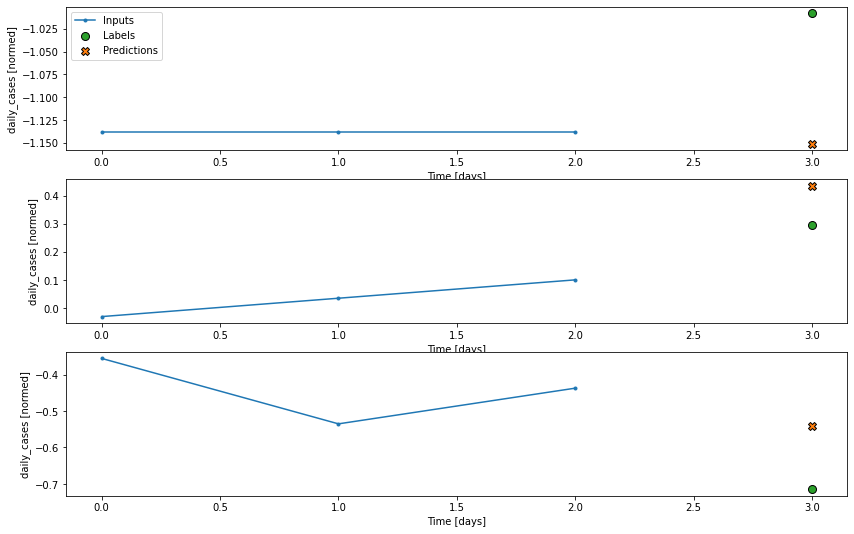

In [202]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. This problem will be fixed with the convolutional neural network (CNN).

#### Model 5: Convolutional Neural Network (CNN)
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

In [203]:
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png?hl=ko")

1. The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
2. The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [204]:
CONV_WIDTH = 3

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [205]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

3/3 [==============================] - 0s 4ms/step - loss: 0.6265 - mean_absolute_error: 0.6567


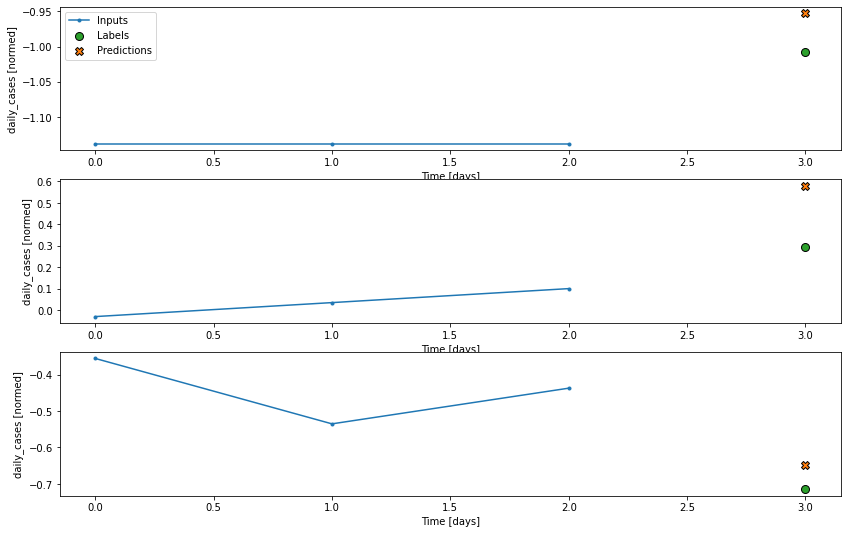

In [206]:
conv_window.plot(conv_model)

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs.

The output is shorter than the input. To make training or plotting work, the labels and prediction should have the same length.

In [207]:
wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['daily_cases']

In [208]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 18)
Labels shape: (32, 30, 1)
Output shape: (32, 28, 1)


In [209]:
# 30 predictions using the 3 days before
LABEL_WIDTH = 30
CONV_WIDTH = 3

INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['daily_cases'])

wide_conv_window

Total window size: 33
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
Label column name(s): ['daily_cases']

In [210]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 32, 18)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


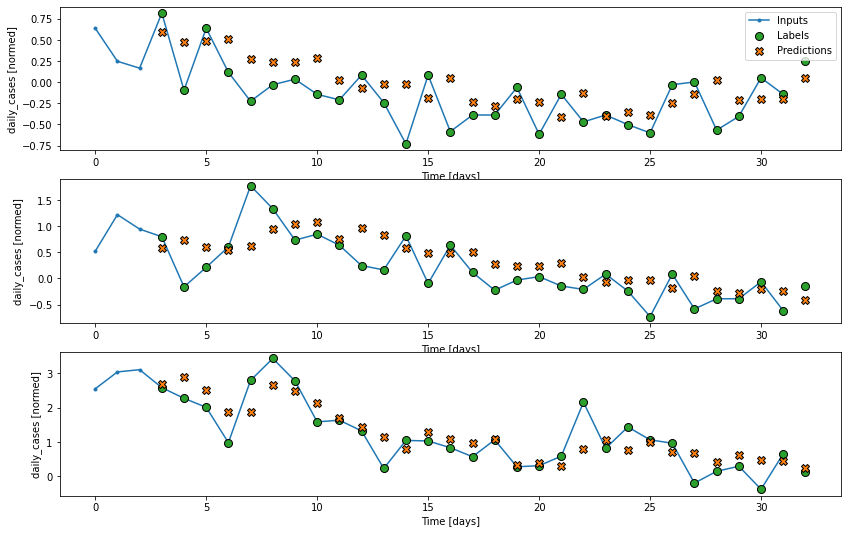

In [211]:
wide_conv_window.plot(conv_model)

#### Model 6: Recurrent Neural Network (RNN)

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

An important constructor argument for all Keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 


In [212]:
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png")

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

In [213]:
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png")

It will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

In [214]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [215]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 18)
Output shape: (32, 30, 1)


In [216]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

2/2 [==============================] - 0s 9ms/step - loss: 0.4806 - mean_absolute_error: 0.4436


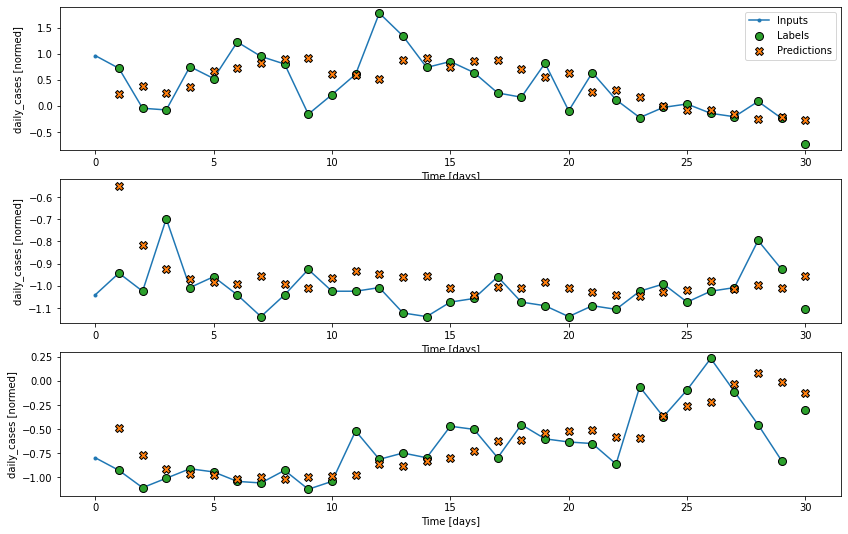

In [217]:
wide_window.plot(lstm_model)

It seems that the best model is the LSTM.

#### Performance
I check if each model is slightly better than the previous one.

In [218]:
performance

{'Baseline': [2.297490119934082, 1.222452998161316],
 'Conv': [2.5206634998321533, 1.125991702079773],
 'Dense': [11.364179611206055, 2.917997121810913],
 'LSTM': [],
 'Linear': [51.10102844238281, 6.420195579528809],
 'Multi step dense': [3.049708604812622, 1.4575127363204956]}

There is an error when `wide_window.test`is evaluated, so only the `wide_window.val` is going to plot.

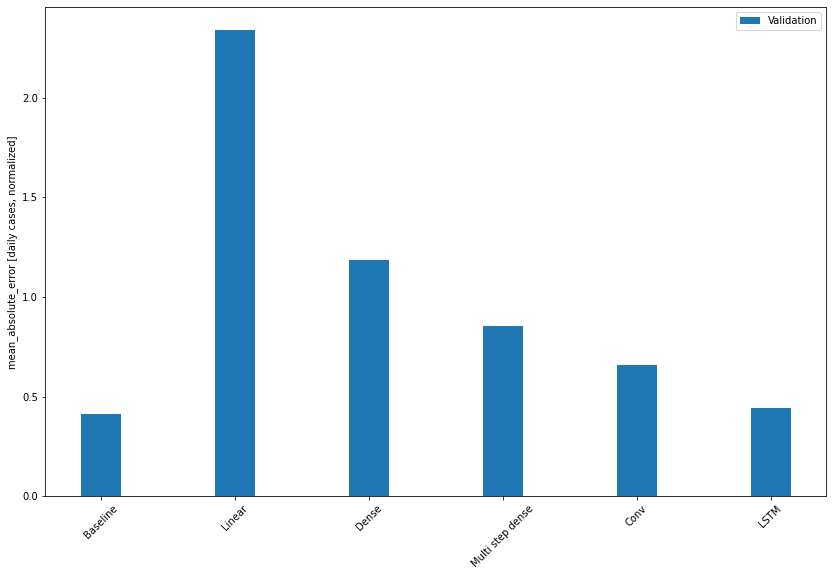

In [219]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [daily cases, normalized]')
plt.bar(x, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


It should be noted that these results are slightly dependent on the randomness with which the sample is chosen.


### Multi-output models<a name="i12"></a>

The models so far all predicted a single output feature, `daily_cases`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.

In [220]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 18)
Labels shape (batch, time, features): (32, 30, 18)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Model 1: Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [221]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [222]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

2/2 [==============================] - 0s 5ms/step - loss: 2.6213 - mean_absolute_error: 0.3711


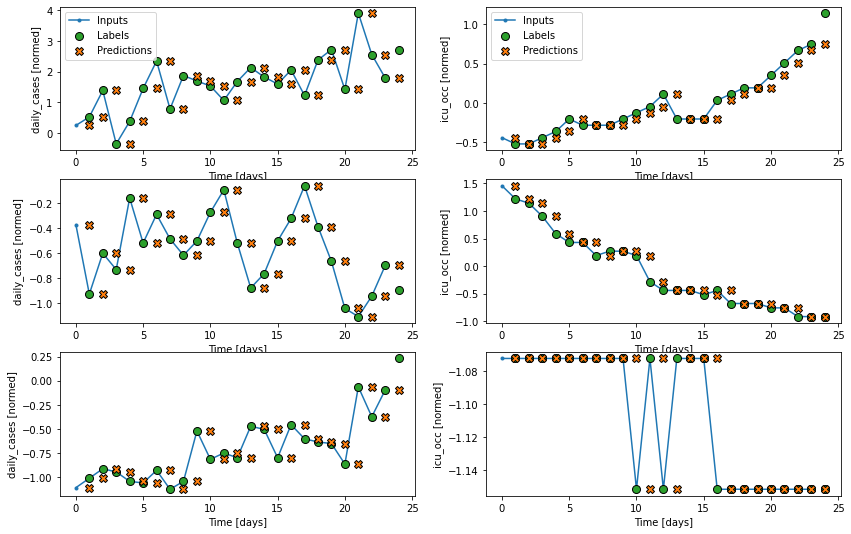

In [245]:
wide_window.plot(baseline, plot_col=['daily_cases', 'icu_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


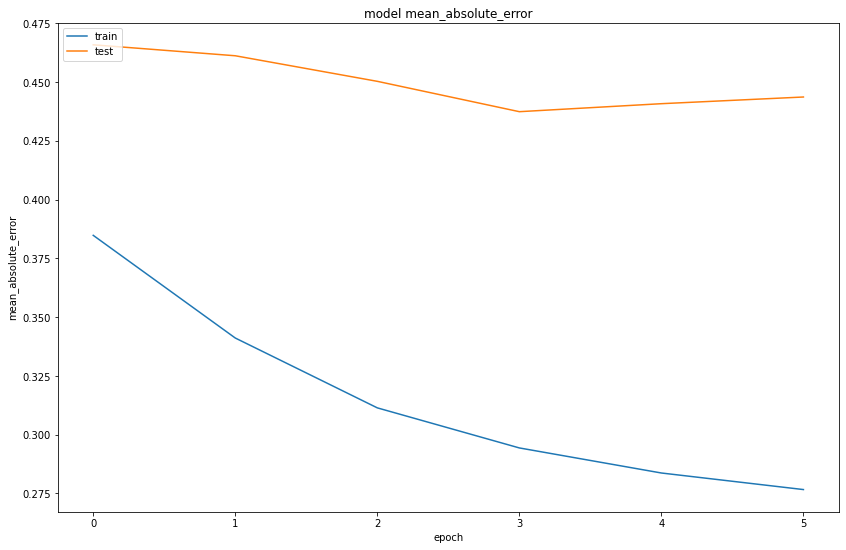

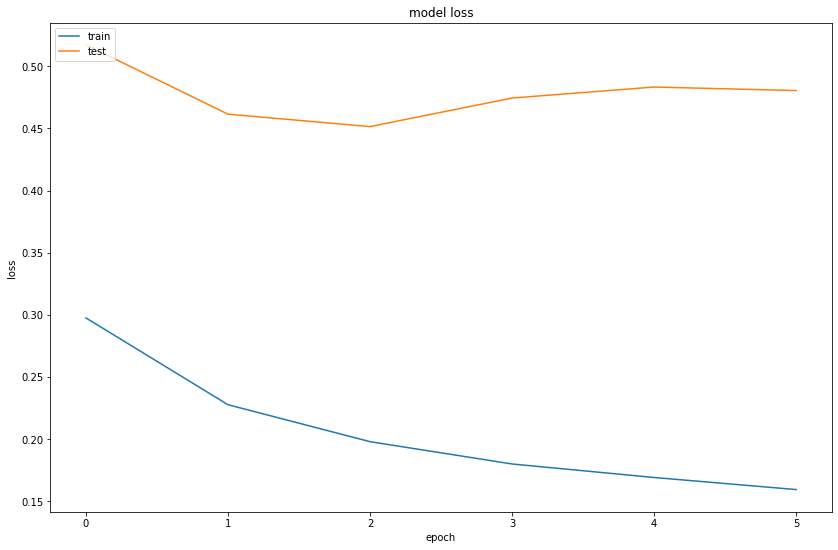

In [224]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 2: Dense

In [225]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [226]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 3.1032 - mean_absolute_error: 0.7605


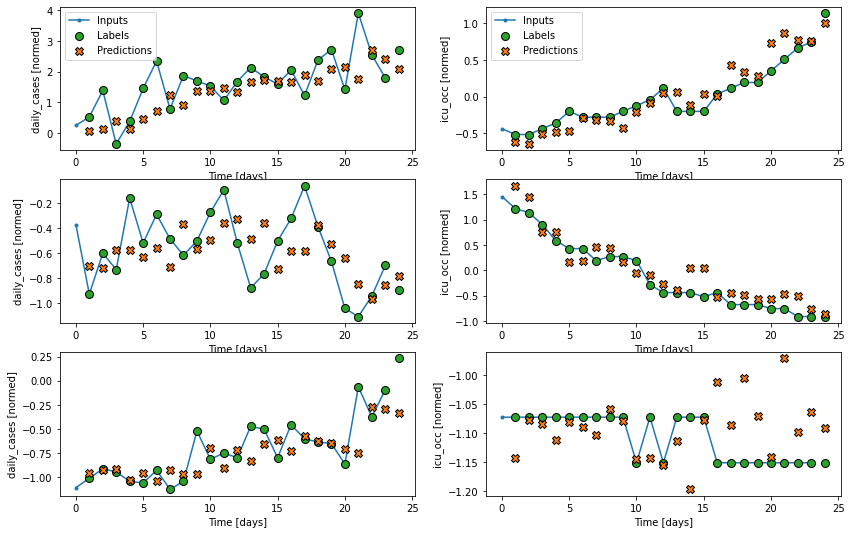

In [244]:
wide_window.plot(dense, plot_col=['daily_cases', 'icu_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


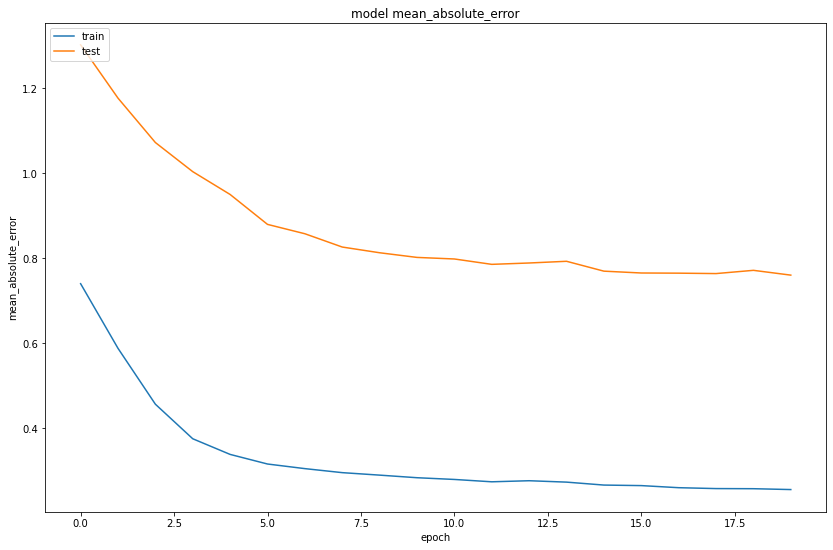

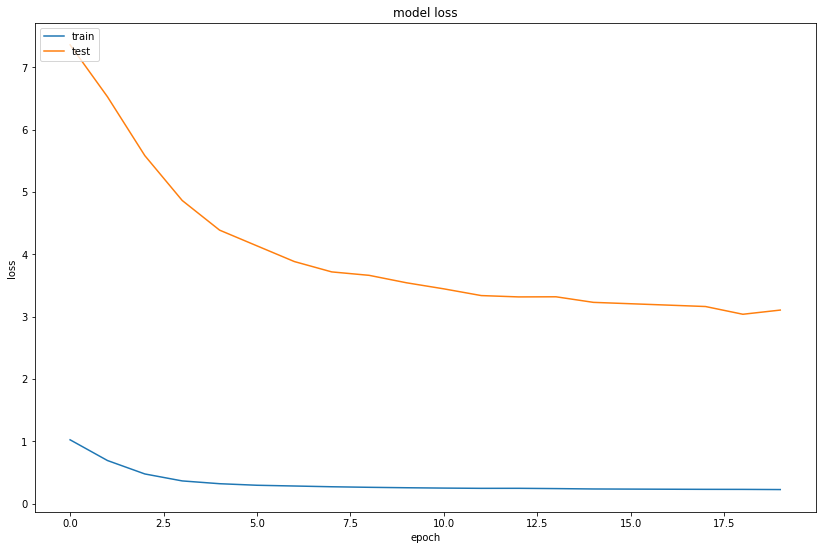

In [228]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 3: RNN

In [231]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window, MAX_EPOCHS=50)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

2/2 [==============================] - 0s 12ms/step - loss: 4.3710 - mean_absolute_error: 0.8954

CPU times: user 19.5 s, sys: 1.2 s, total: 20.7 s
Wall time: 19.9 s


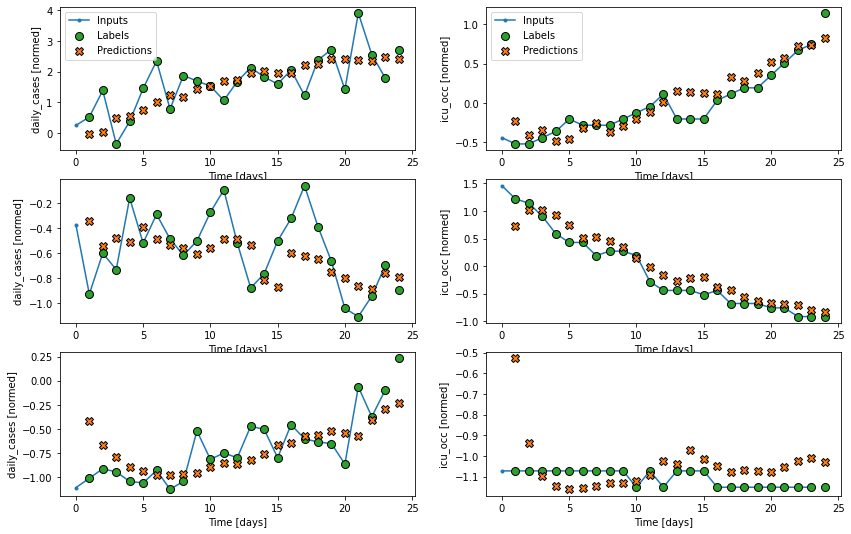

In [243]:
wide_window.plot(lstm_model, plot_col=['daily_cases', 'icu_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


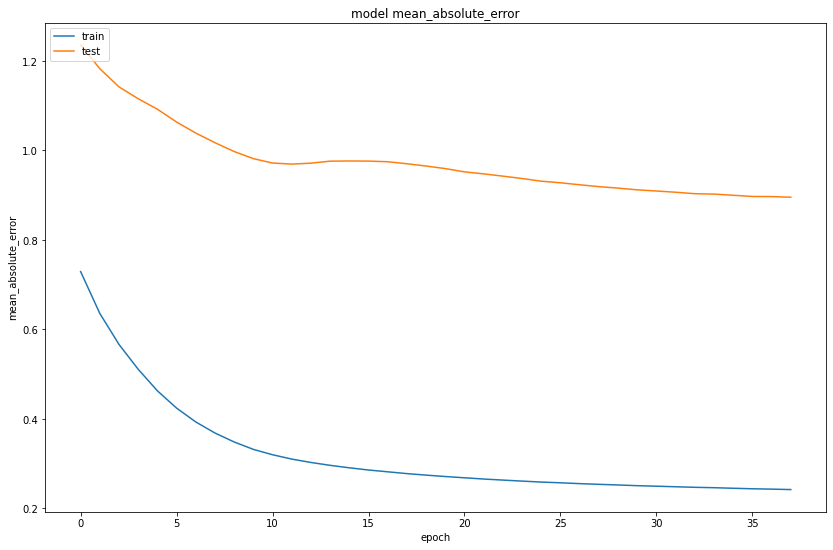

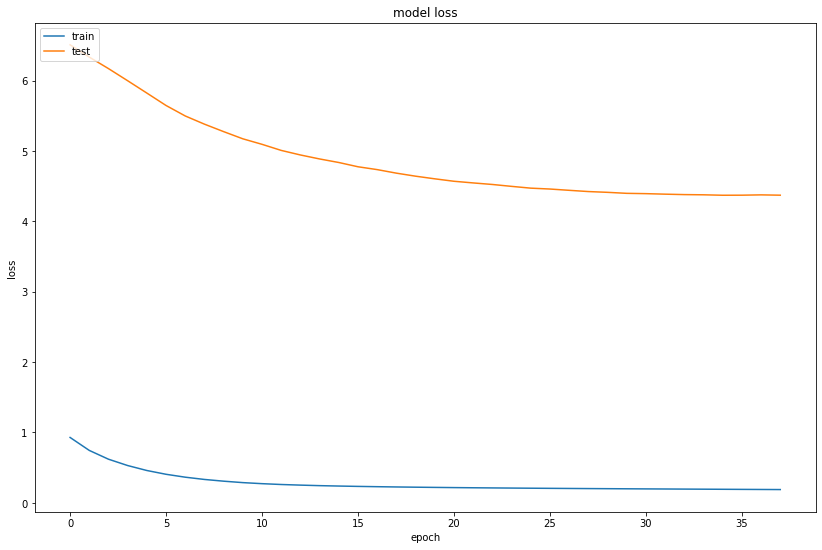

In [233]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 4: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step.

In [234]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/residual.png")

Essentially, this initializes the model to match the `Baseline`. This approach can be used in conjunction with any model discussed. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [235]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [238]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

2/2 [==============================] - 0s 10ms/step - loss: 2.6395 - mean_absolute_error: 0.5154

CPU times: user 6.06 s, sys: 255 ms, total: 6.31 s
Wall time: 5.96 s


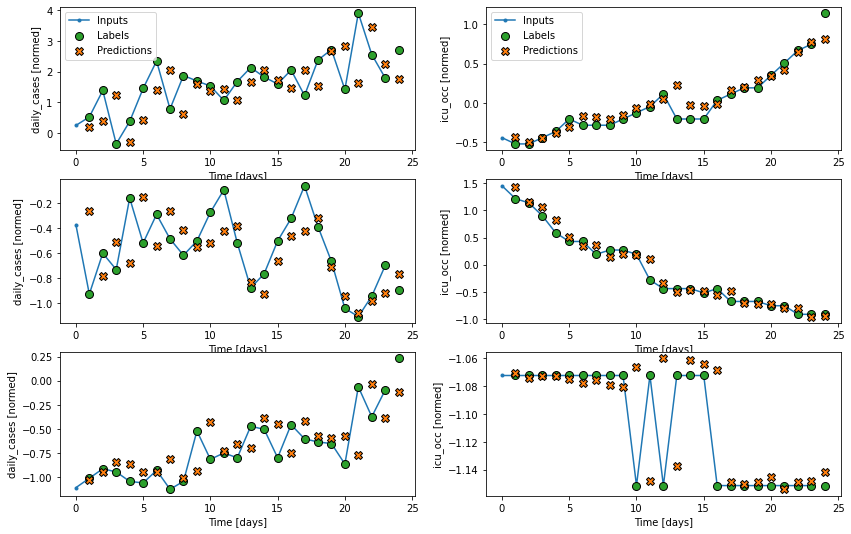

In [246]:
wide_window.plot(residual_lstm, plot_col=['daily_cases', 'icu_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


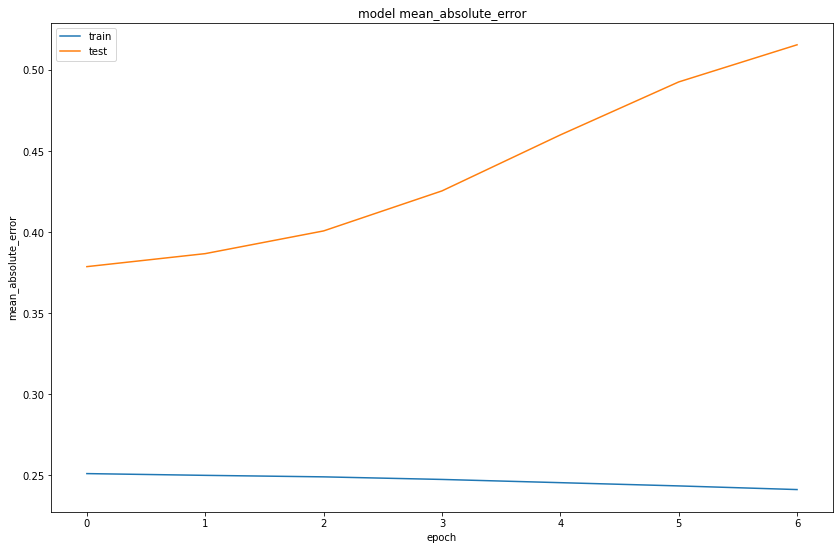

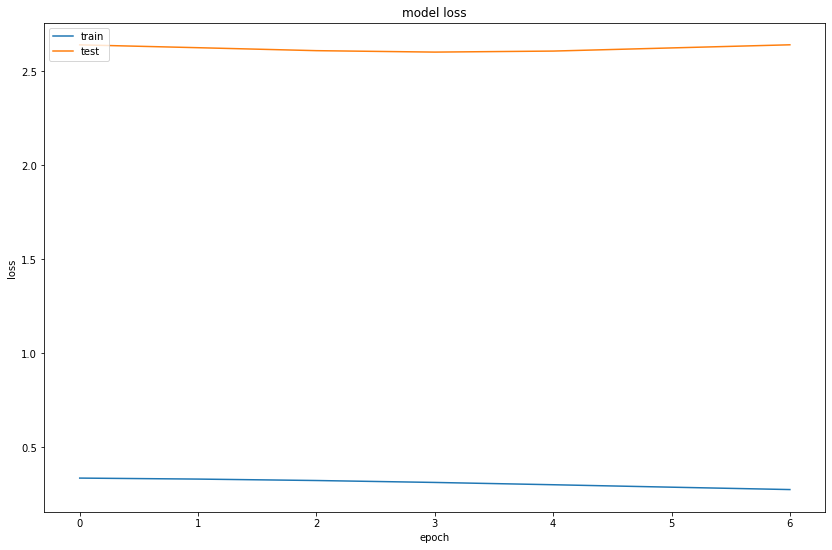

In [240]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Performance

In [241]:
performance

{'Baseline': [],
 'Dense': [15.96237850189209, 2.027953863143921],
 'LSTM': [29.59726905822754, 2.4218950271606445],
 'Residual LSTM': [11.621376991271973, 0.9071013927459717]}

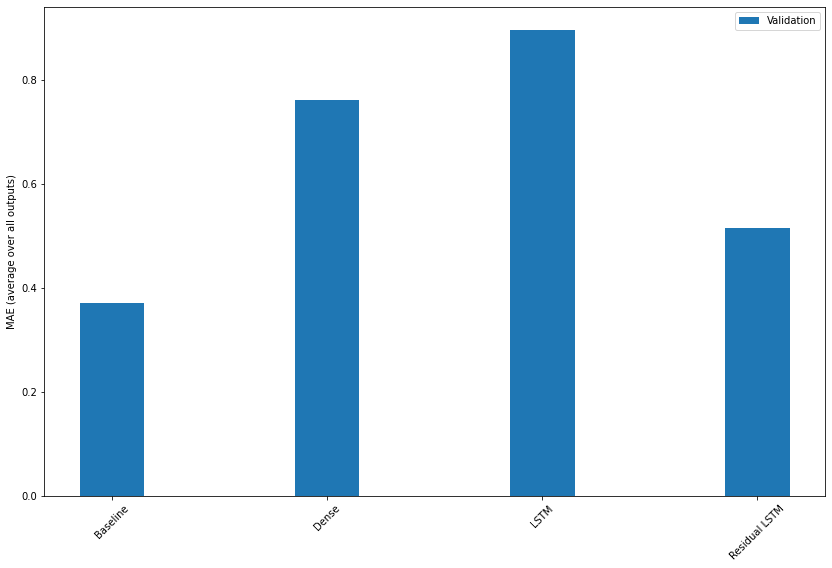

In [242]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

## Multi-step models<a name="i2"></a>
Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one day into the future. Now these models will make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.

The models will learn to predict 14 days into the future, given 30 days of the past.

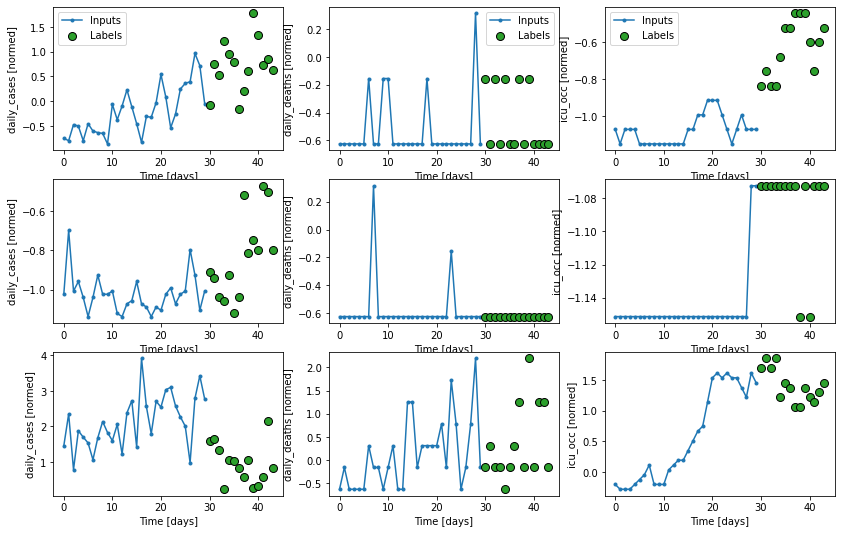

Total window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): None

In [250]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(plot_col=['daily_cases', 'daily_deaths', 'icu_occ'])
multi_window

#### Baseline
A simple baseline for this task is to repeat the last input time step for the required number of output time steps.

In [251]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_last.png")

2/2 [==============================] - 0s 10ms/step - loss: 5.4553 - mean_absolute_error: 0.7053


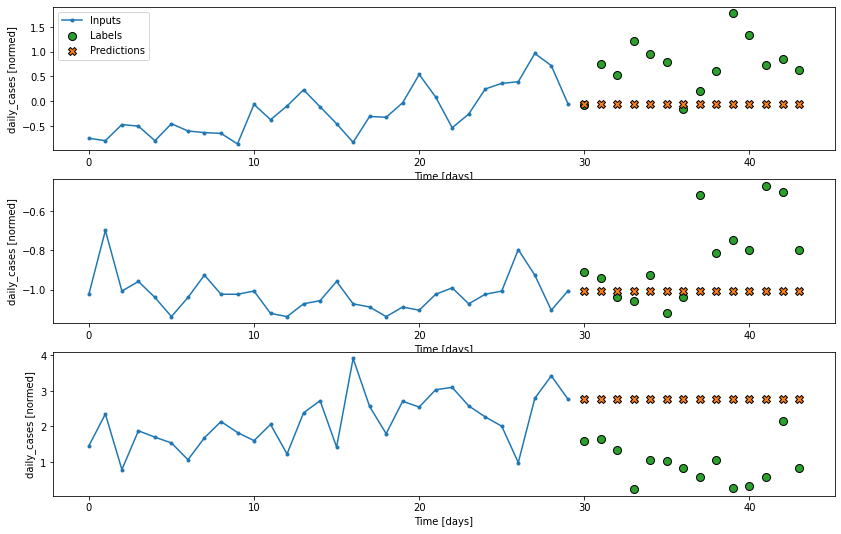

In [252]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Another simple approach is to repeat the previous day, assuming tomorrow will be similar. In this case, the model will learn to predict 14 future days given the same number of past days.

In [253]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_repeat.png")

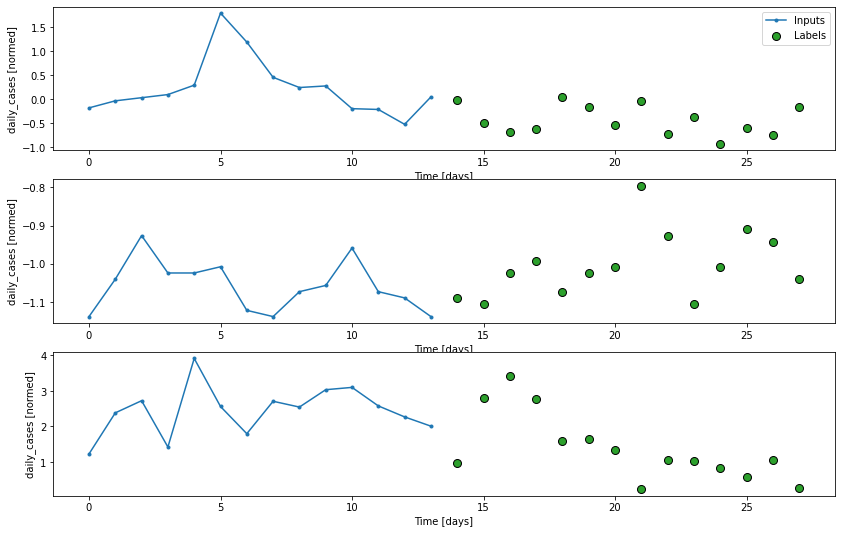

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

In [254]:
# 14 future days
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

2/2 [==============================] - 0s 6ms/step - loss: 0.8092 - mean_absolute_error: 0.5079


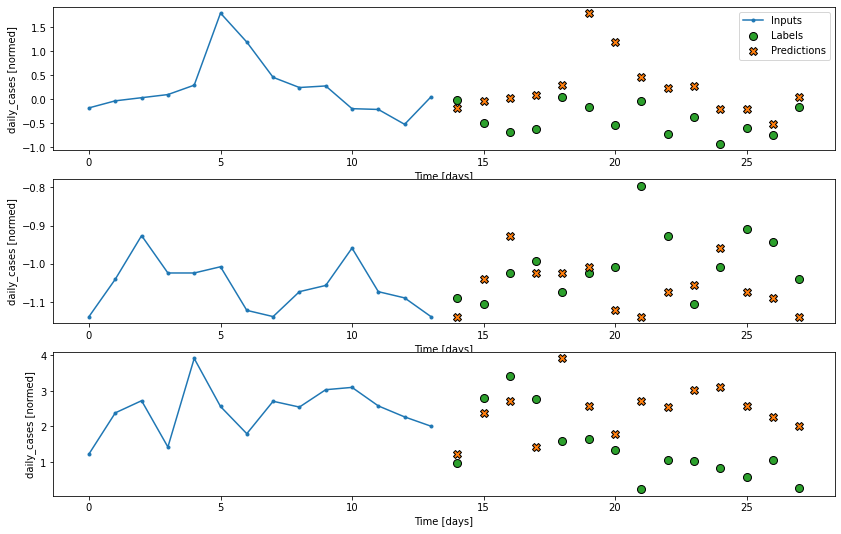

In [255]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


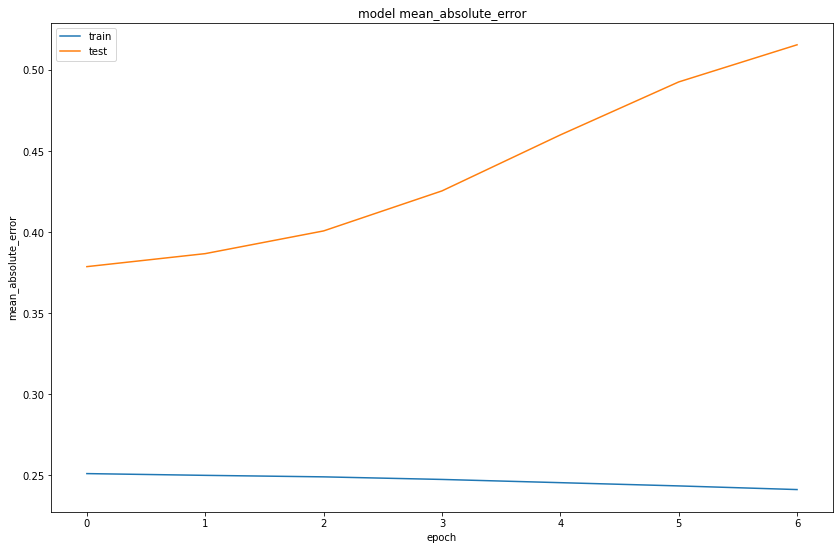

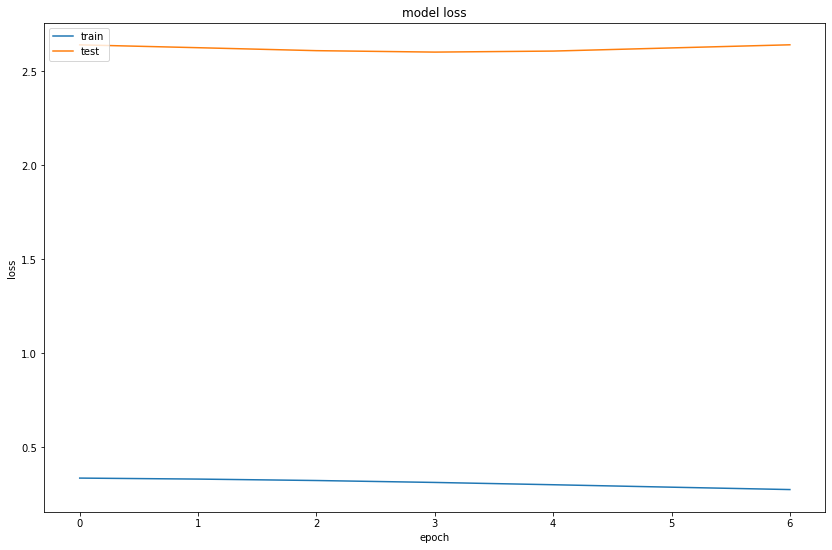

In [256]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Single-shot models<a name="i21"></a>

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

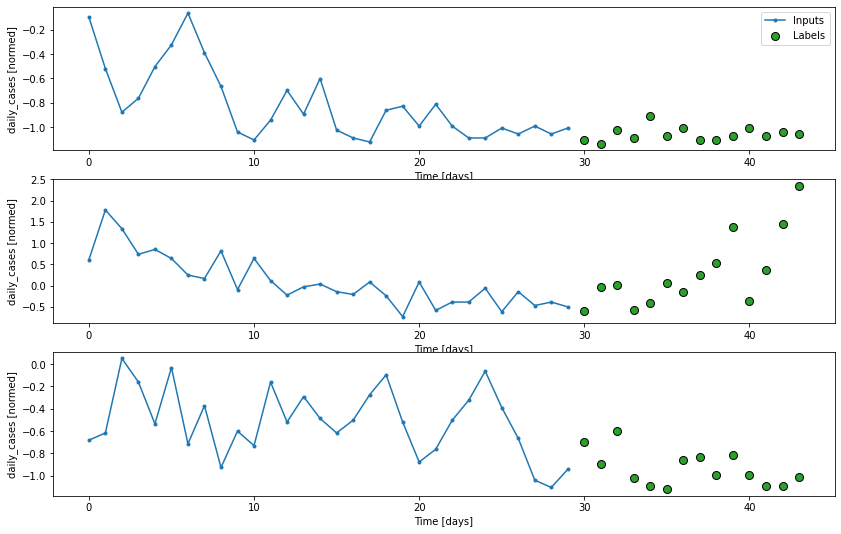

Total window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): None

In [257]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Model 1: Linear
A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of month and year.

In [258]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png")

2/2 [==============================] - 0s 5ms/step - loss: 7.8428 - mean_absolute_error: 1.2845


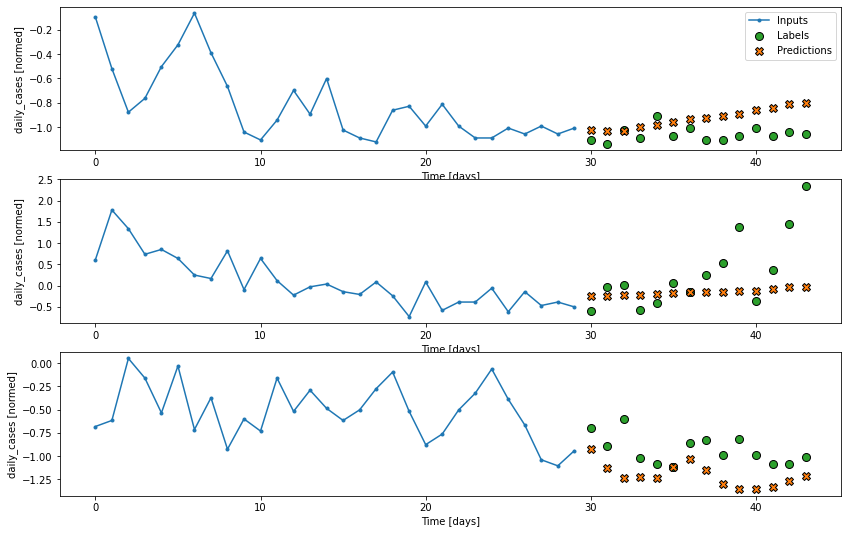

In [259]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


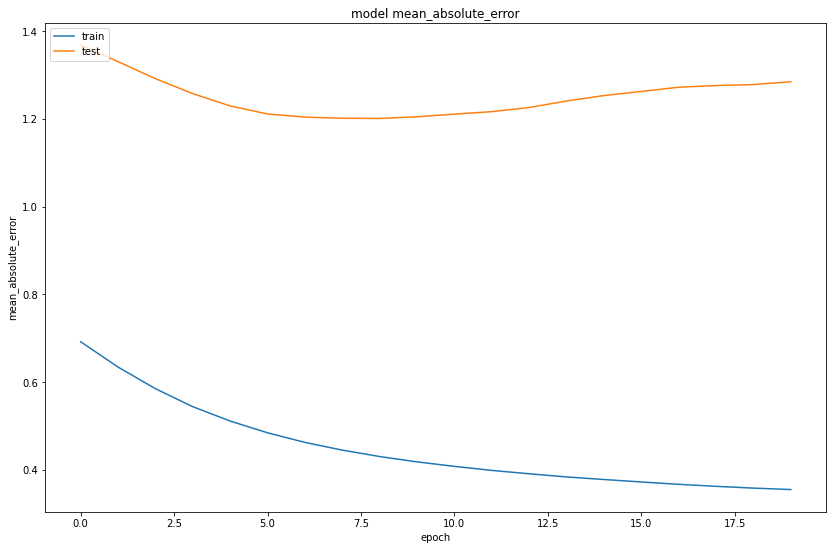

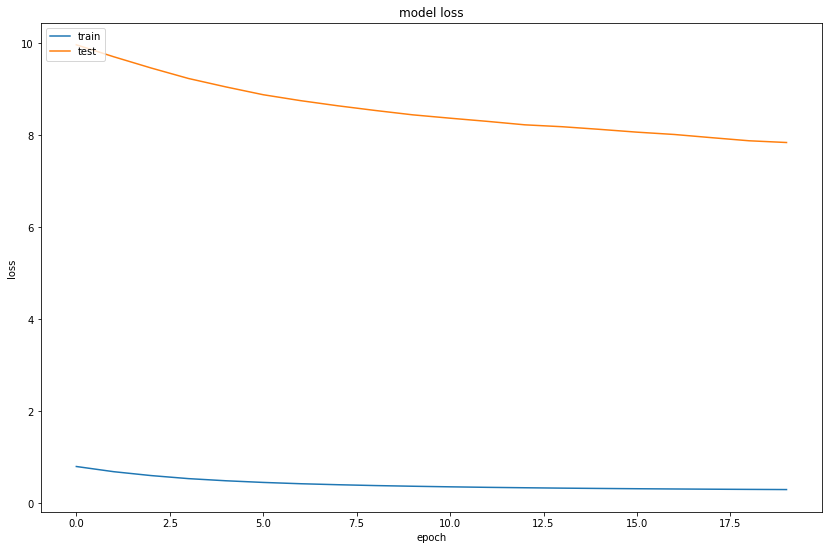

In [260]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 2: Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

2/2 [==============================] - 0s 6ms/step - loss: 5.4607 - mean_absolute_error: 1.0220


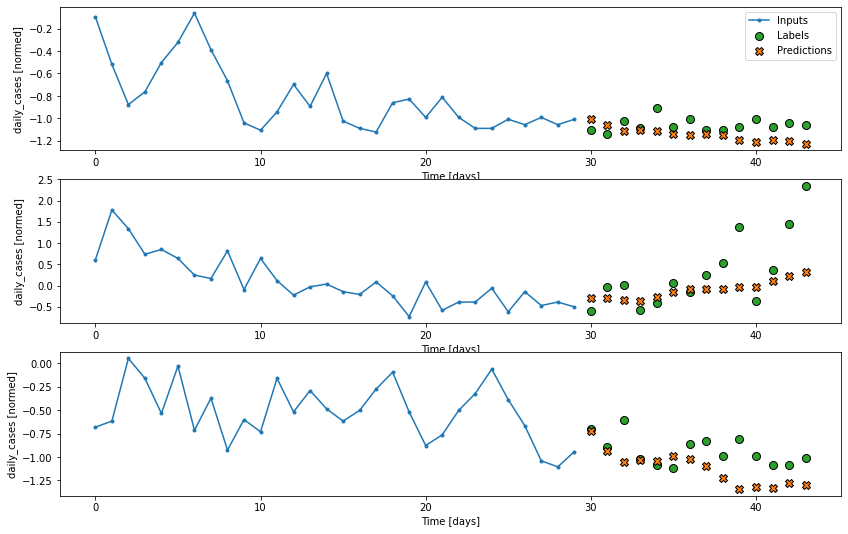

In [262]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


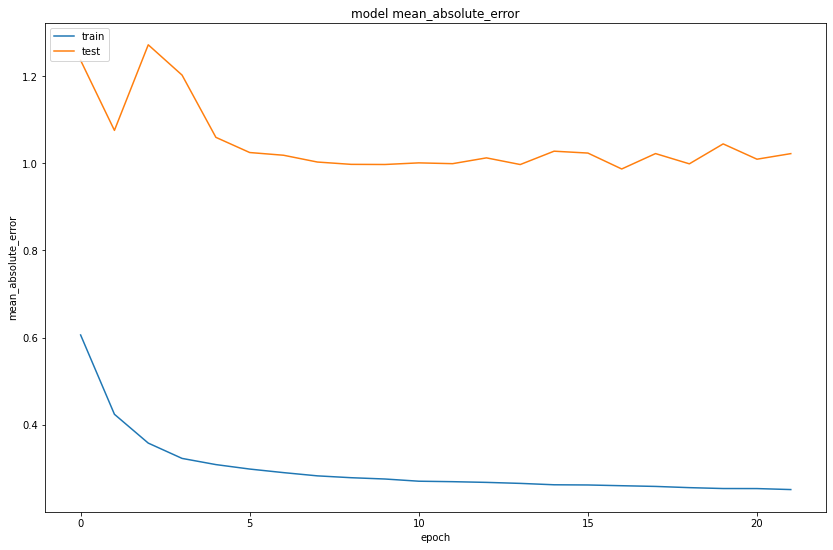

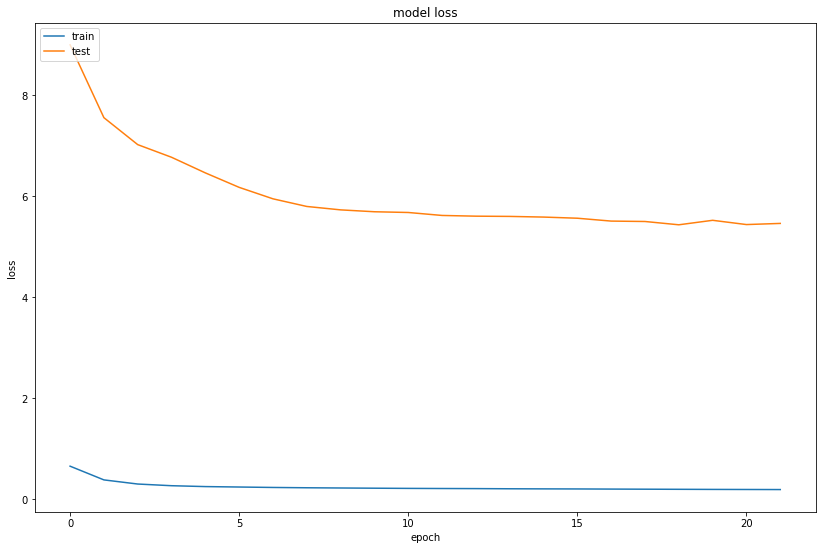

In [263]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 2 Advance: Feed Forward Neural Network

In [264]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

# multi_window.plot()
multi_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): None

In [265]:
def ffnn(layer_num, layer_cells, out_steps, num_features=18, dropout_rate=0.05):
    """
    Create a custom Feed Forward Neural Network.
    Args:
        layer_num: Number of hidden layers.
        layer_cells: Number of neurones in each hidden layer.
        out_steps: Time instants to be predicted (t_final = t + out_steps).
        num_features: Number of features (columns) to use in the predictions.
        dropout_rate: (0-1). Percentage of randomly selected neurons or units (hidden and visible) that will be ignored
                    during training to prevent NN from overfitting.

    Returns: Feed Forward Neural Network model.

    """

    model = Sequential()
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    model.add(Lambda(lambda x: x[:, -1:, :]))

    for i in range(layer_num):
        model.add(Dense(layer_cells,
                        activation="relu",
                        kernel_initializer="he_uniform",
                        name=f"dense{i}"))
        model.add(Dropout(dropout_rate))

    model.add(Dense(out_steps * num_features,
                    activation="relu"))

    model.add(Dense(out_steps * num_features,
                    kernel_initializer=tf.initializers.zeros()))
    # Shape => [batch, out_steps, features].
    model.add(Reshape([out_steps, num_features]))
    return model

1/1 [==============================] - 0s 48ms/step - loss: 5.6419 - mean_absolute_error: 1.0323


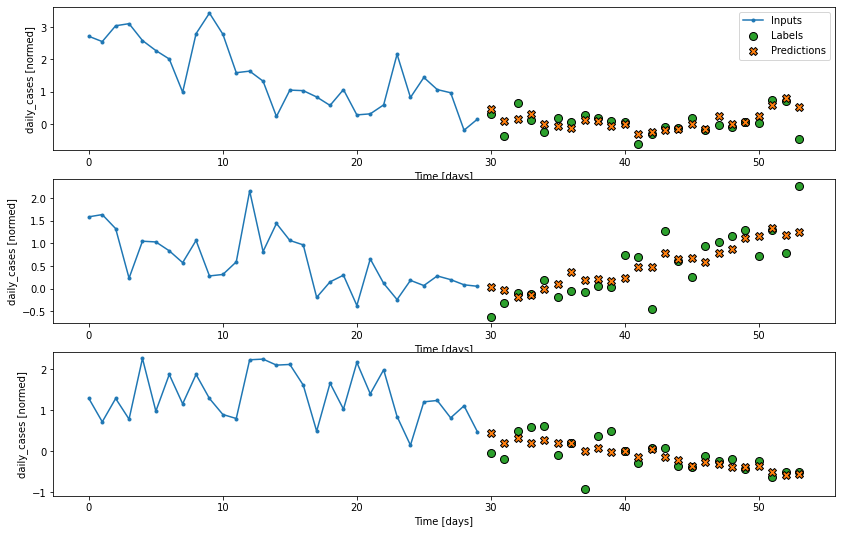

In [266]:
multi_ffnn_model = ffnn(layer_num=2, layer_cells=500, out_steps=24, dropout_rate=0)

history = compile_and_fit(multi_ffnn_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()
multi_val_performance['FFNN'] = multi_ffnn_model.evaluate(multi_window.val)
multi_performance['FFNN'] = multi_ffnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_ffnn_model)

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


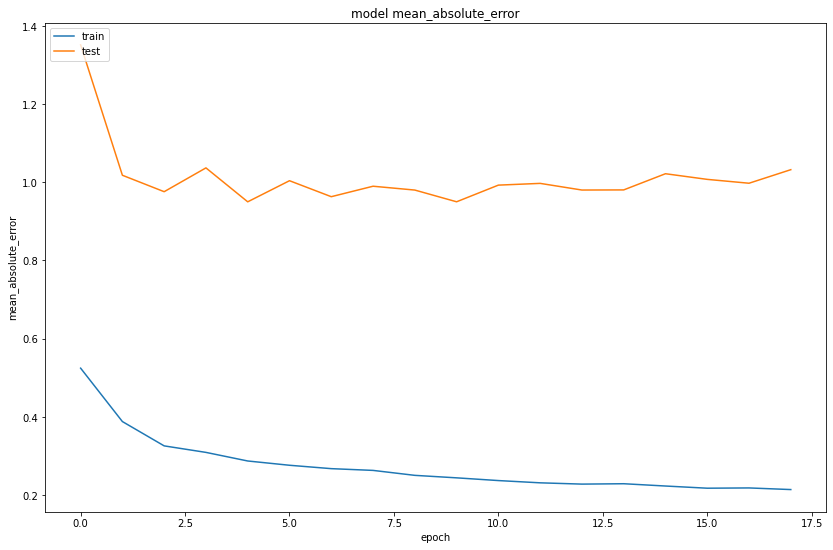

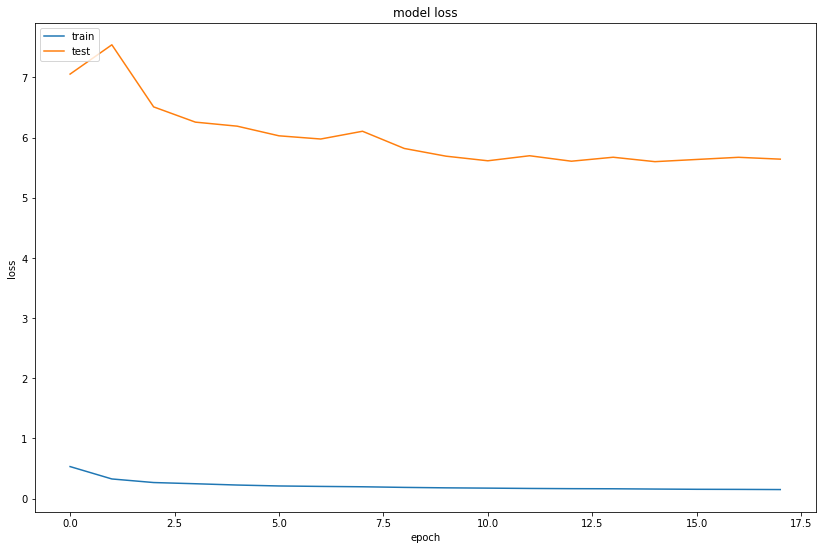

In [267]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### CNN
A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time.

In [268]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png")

For the CNN, 20 past days (`CONV_WIDTH`) and 30 epochs will be used to predict 5 future days.

2/2 [==============================] - 0s 7ms/step - loss: 2.7788 - mean_absolute_error: 0.8949


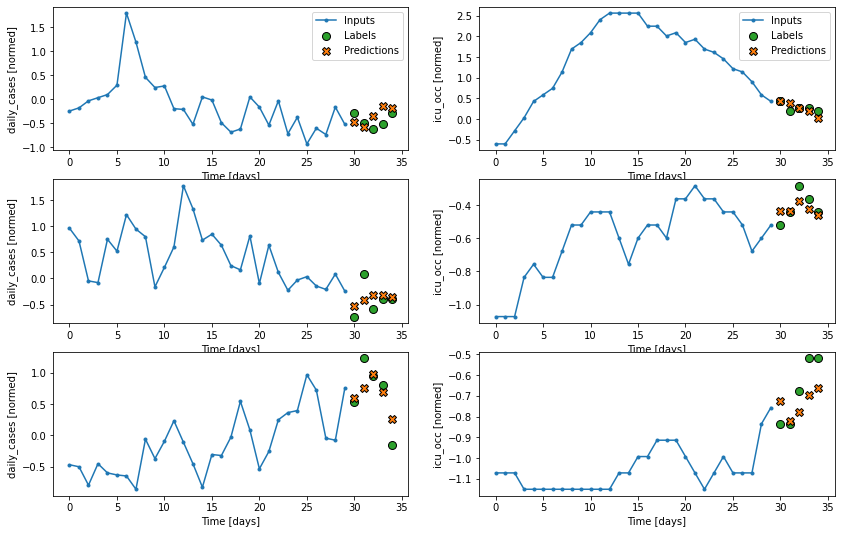

In [276]:
OUT_STEPS = 5
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 20


multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col=['daily_cases', 'icu_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


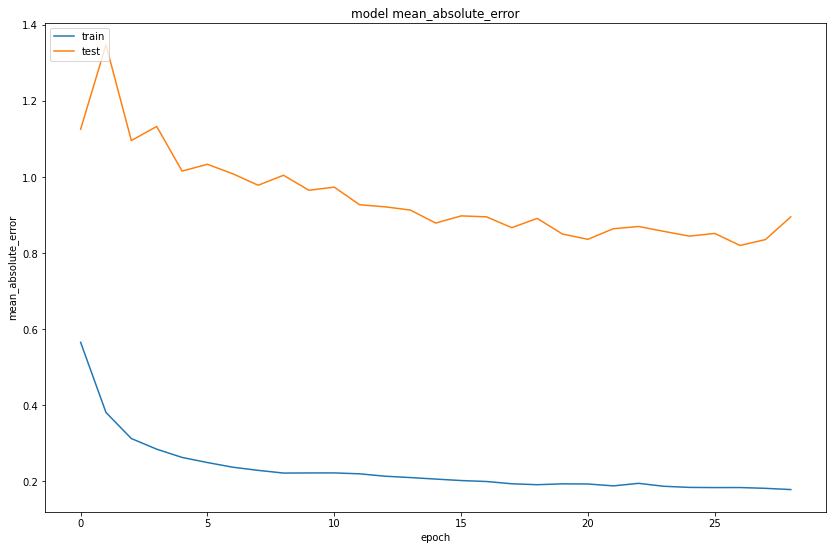

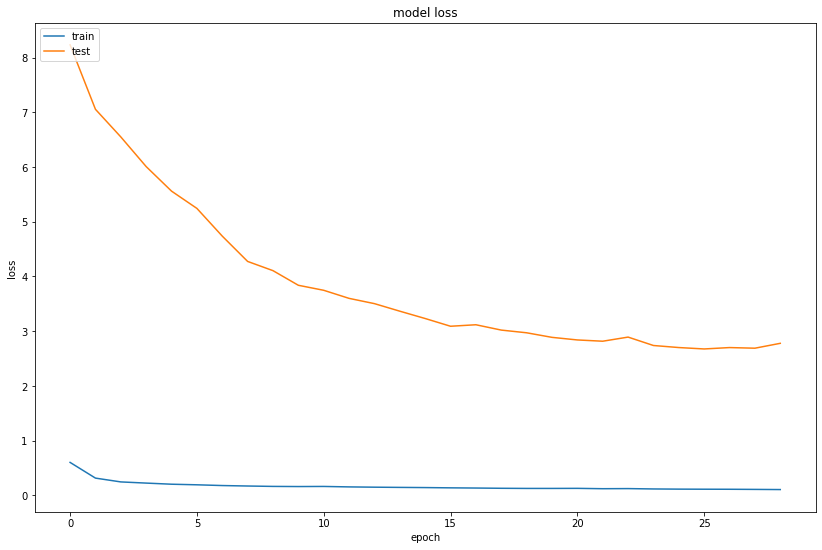

In [277]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### RNN
A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 30 days, before making a single prediction for the next 14 days.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

In [278]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png")

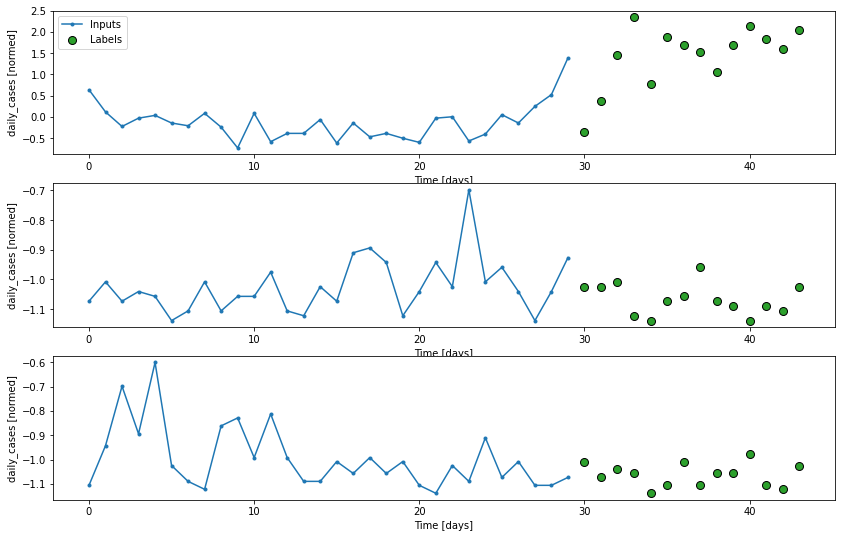

In [279]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()

2/2 [==============================] - 0s 8ms/step - loss: 7.5477 - mean_absolute_error: 1.1879


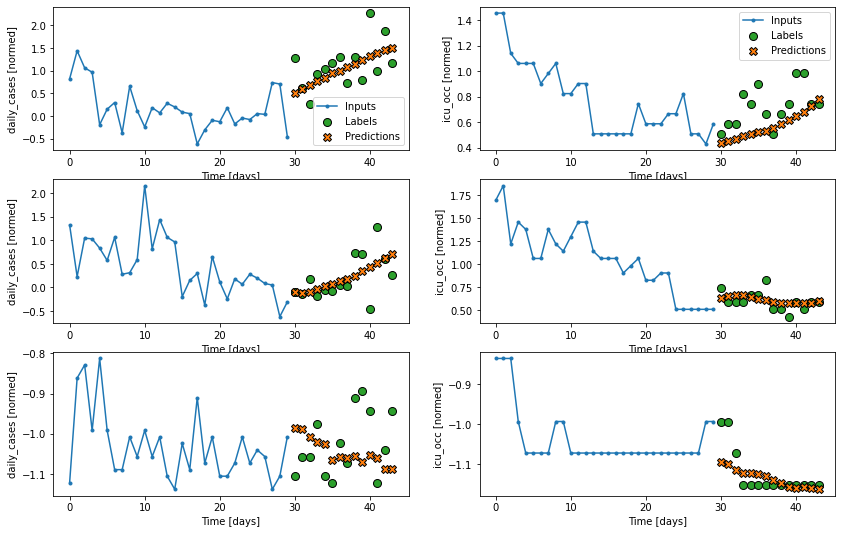

In [275]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(69, return_sequences=False),
    tf.keras.layers.Dropout(0),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(500,
    #                 activation="relu"),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
  #  tf.keras.layers.Dropout(0.05),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=['daily_cases', 'icu_occ'])

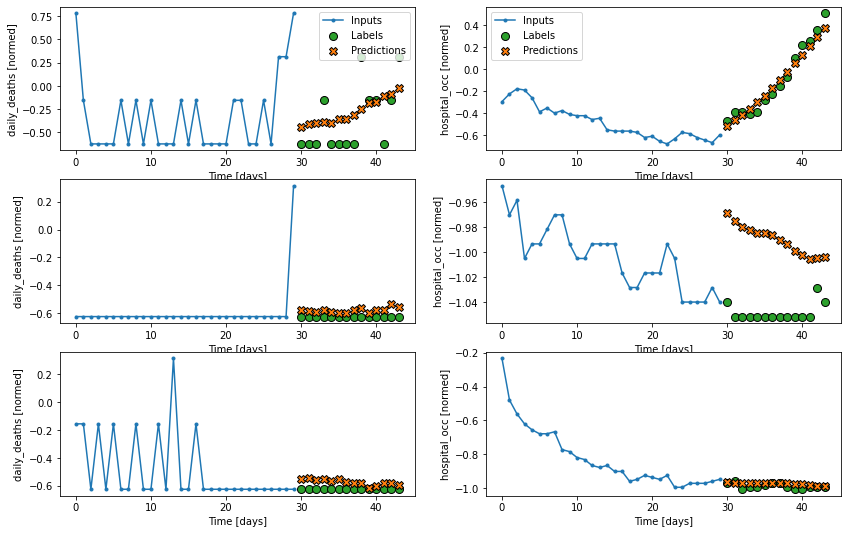

In [280]:
multi_window.plot(multi_lstm_model, plot_col=['daily_deaths', 'hospital_occ'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


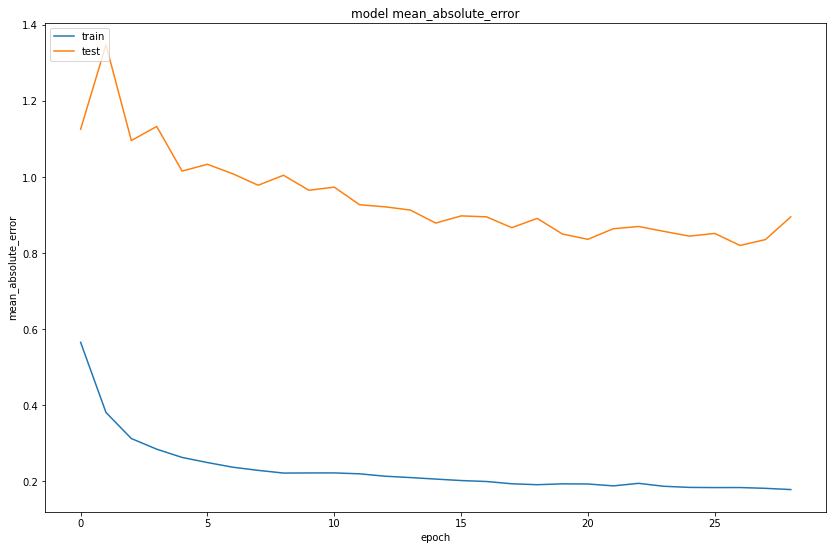

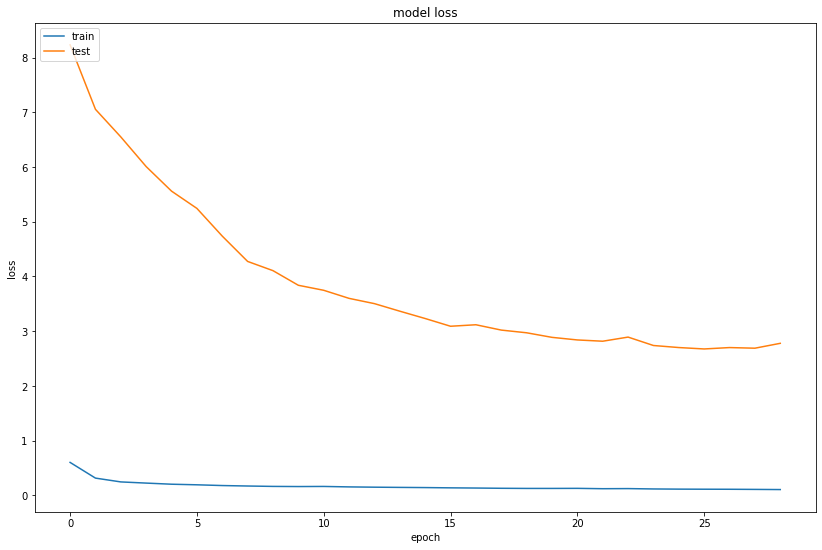

In [281]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Advance: Autoregressive model<a name="i22"></a>
The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

In [282]:
Image(url="https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png")

##### RNN

Only an autoregressive RNN model will be built, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence result.

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [283]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [284]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier.

In [285]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [286]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 18])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

In [287]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [288]:
print('Input shape (batch, time, features): ',multi_window.example[0].shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Input shape (batch, time, features):  (32, 30, 18)
Output shape (batch, time, features):  (32, 14, 18)


Now, train the model.

2/2 [==============================] - 0s 9ms/step - loss: 7.9586 - mean_absolute_error: 1.2319


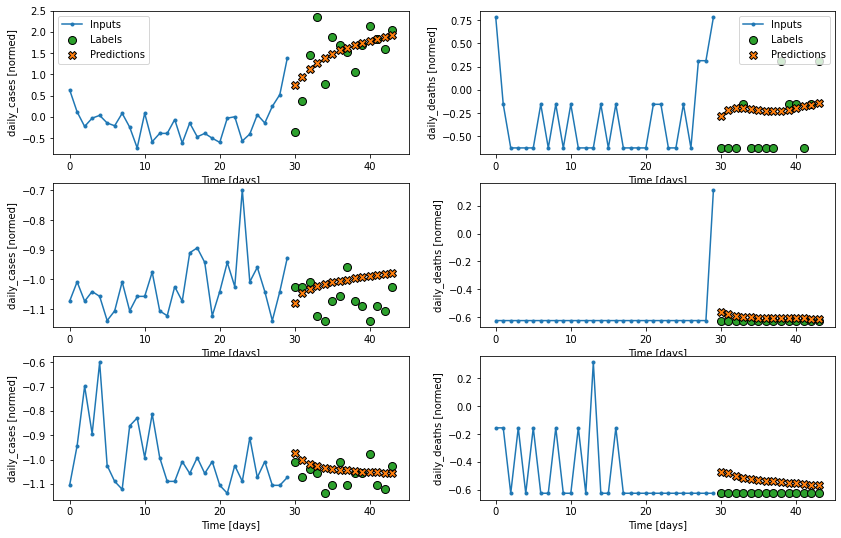

In [295]:
history = compile_and_fit(feedback_model, multi_window, MAX_EPOCHS=50)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col=['daily_cases', 'daily_deaths'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


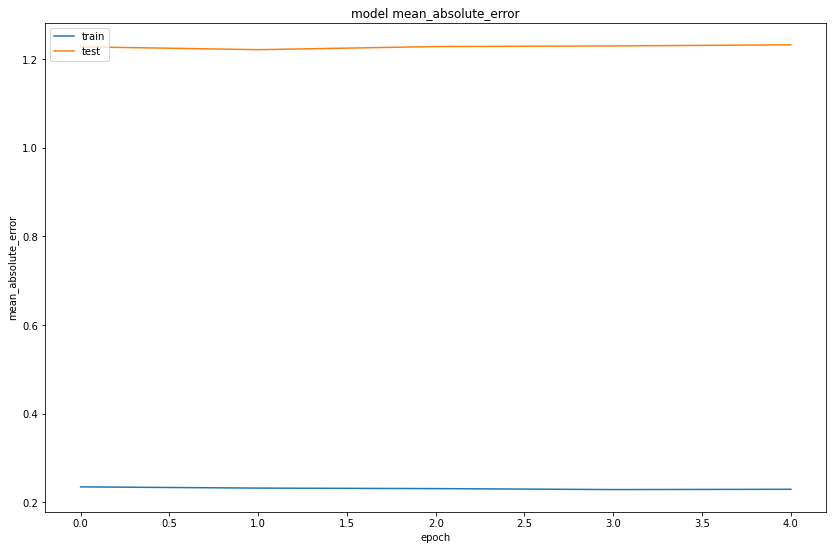

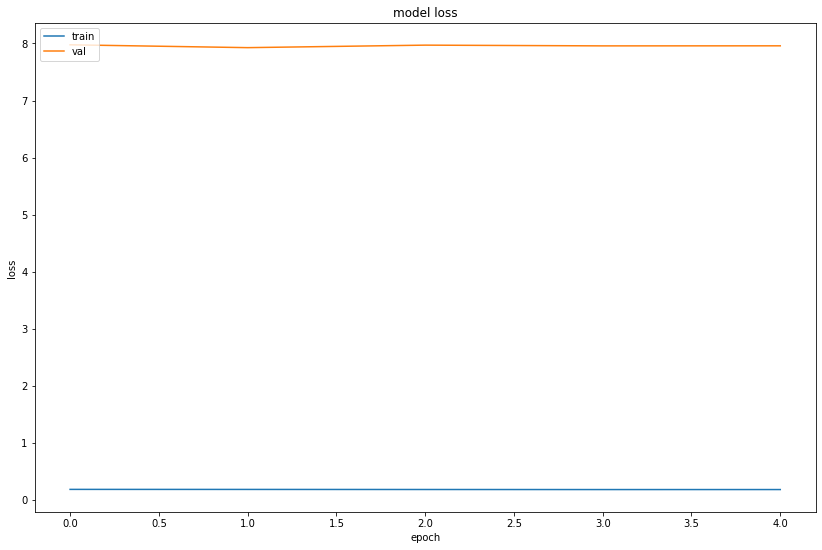

In [296]:
# list all data in history
print((history.history.keys()))
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Performance

In [293]:
multi_val_performance

{'AR LSTM': [7.947170734405518, 1.2206010818481445],
 'Conv': [2.778769016265869, 0.8949235677719116],
 'Dense': [5.641903400421143, 1.0322506427764893],
 'LSTM': [7.547664165496826, 1.1879340410232544],
 'Last': [5.4552531242370605, 0.7052872180938721],
 'Linear': [7.842809200286865, 1.2845159769058228],
 'Repeat': [0.8092423677444458, 0.5078532099723816]}

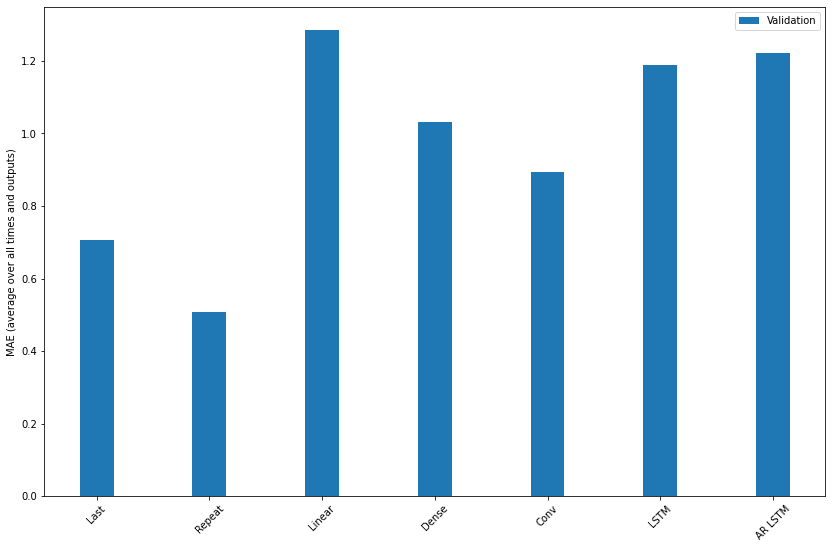

In [294]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
# test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

These more complex approaches may not be worth while on this problem, but there was no way to know without trying.